In [1]:
import pickle
with open("noniid_ae_train.txt", "rb") as fp:
    (train_x, train_y) = pickle.load(fp)
with open("noniid_ae_test.txt", "rb") as fp:
    (test_x, test_y) = pickle.load(fp)

In [2]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import PIL
from PIL import Image

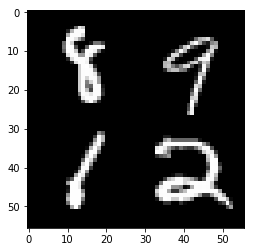

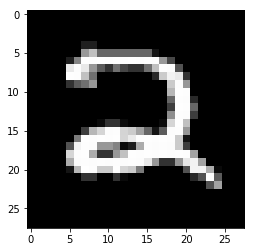

In [3]:
image = PIL.Image.fromarray(np.squeeze(train_x[8]) )
plt.imshow(image)
plt.show()
image = PIL.Image.fromarray(np.squeeze(train_y[8]) )
plt.imshow(image)
plt.show()

In [4]:
class PVRAEDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, X, z):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.X = (torch.tensor(X, dtype = torch.float)/255 - 0.5)/0.5
        self.z = (torch.tensor(z, dtype = torch.float)/255 - 0.5)/0.5
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.z[idx]

In [5]:
trainset = PVRAEDataset(train_x, train_y)
testset = PVRAEDataset(test_x, test_y)

In [6]:
train_loader = DataLoader(trainset, batch_size=64, shuffle=True,num_workers=1)
test_loader = DataLoader(testset, batch_size=64, shuffle=False,num_workers=1)

In [7]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 16), 3x3 kernels
       
        self.net1_conv1 = nn.Conv2d(1, 16, 3, padding=1)  
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.net1_conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        self.lin = nn.Linear(784, 196)
        
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(4, 7, 7))
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)
        
        self.net2_conv1 = nn.Conv2d(1, 16, 3, 1)
        self.net2_conv2 = nn.Conv2d(16, 8, 3, 1)
        self.net2_fc = nn.Linear(1352, 784)


    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        xx = self.net2_conv1(x)
        xx = self.net2_conv2(xx)
        xx = self.pool(xx)
        xx = self.pool(xx)
        xx = torch.flatten(xx, 1)
        xx = self.net2_fc(xx)
        
        
        x = self.net1_conv1(x)
        x = self.pool(x)
        # add second hidden layer
        x = self.net1_conv2(x)
        x = self.pool(x)  # compressed representation
        
        x = torch.flatten(x, 1)
        
        #x = torch.cat((x, xx), dim = 1)
        x = x * xx
        
        x = self.lin(x)
        
        x = self.unflatten(x)
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.tanh(self.t_conv2(x))
        return x

# initialize the NN
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (net1_conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (net1_conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lin): Linear(in_features=784, out_features=196, bias=True)
  (unflatten): Unflatten(dim=1, unflattened_size=(4, 7, 7))
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
  (net2_conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (net2_conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1))
  (net2_fc): Linear(in_features=1352, out_features=784, bias=True)
)


In [9]:
criterion = nn.MSELoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 10
for e in range(1, epochs+1):
    train_loss = 0.0  # monitor training loss
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        
        images, labels = data                        # we are just intrested in just images

        # no need to flatten images
        optimizer.zero_grad()                   # clear the gradients
        outputs = model(images)            # forward pass: compute predicted outputs 
        loss = criterion(outputs, labels)       # calculate the loss
        loss.backward()                         # backward pass
        optimizer.step()                        # perform optimization step
        train_loss += loss.item()*images.size(0)# update running training loss
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {}'.format(e),
          '\tTraining Loss: {:.4f}'.format(train_loss))

Epoch: 1 	Training Loss: 4.5019
Epoch: 2 	Training Loss: 4.2158
Epoch: 3 	Training Loss: 4.0175
Epoch: 4 	Training Loss: 3.8264
Epoch: 5 	Training Loss: 3.6577
Epoch: 6 	Training Loss: 3.4991
Epoch: 7 	Training Loss: 3.3651
Epoch: 8 	Training Loss: 3.2356
Epoch: 9 	Training Loss: 3.1291
Epoch: 10 	Training Loss: 3.0405


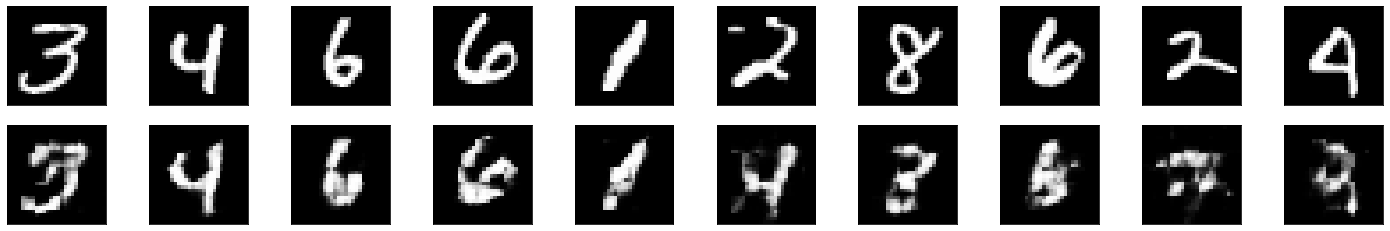

In [12]:
dataiter = iter(test_loader)
images, labels = dataiter.next()


output = model(images)                     # get sample outputs
labels = labels.numpy()                    # prep images for display
imgs = images.numpy()


output = output.view(64, 1, 28, 28)# resizing output
output = output.detach().numpy()           # use detach when it's an output that requires_grad

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))
# input images on top row, reconstructions on bottom
for images, row in zip([labels, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
